### CORRECTING THE CATASTROPHIC ERRORS IN RADIAL VELOCITY

Due to the Doppler dilemma which states that the maximum unambiguous velocity can be increased only at the expense of the reduction of maximum unambiguous range, some techniques were developed in order to circumvent this constraint in Doppler weather radars. Among these is the staggered PRT technique which was first proposed by Sirmans et al. (1976) and later by Zrnic and Mahapatra (1985). This technique makes use of alternating pulse repetition times (henceforth PRT) $T_{1}$ and $T_{2}$, where $T_{1}<T_{2}$ in order to achieve an extended maximum unambiguous velocity interval, without the need to reduce de maximum unambiguous range. PRTs are picked such that $T_{1}$ and $T_{2}$ are prime integers, where $K = T_{1}/T_{2} = m/n$ is the PRT ratio, and $K$ is usually 1/2, 2/3, 3/4, or 4/5.

As shown by Torres et al. (2004), radial velocities aliase at different intervals for each of the PRTs, and, therefore, radial velocities estimated from one of the PRTs can be used to dealiase the other following a set of predetermined dealiasing rules which I'm not going to delve into (see Torres et al. 2004 for more info). However, some considerations must be taken into accout when using this technique. First of, as shown by Zrnic and Mahapatra (1985), the variance of radial velocities is inversely proportional to the difference between $T_{1}$ and $T_{2}$, and if $K\rightarrow 1$, the statistical errors may be too large and the quality of velocity estimates will be significantly degraded. Hence, the dealiasing algorithm will unfold the wrong velocity using the wrong yelding a completely incorrect velocity stimate also known as a "catastrophic error". However, it's possible to reduce the amount of catastrophic errors by reducing the ratio $K$, with 2/3 being a good choice as shown in the literature (e.g., Sachidananda and Zrnic 2000, 2002, Torres et al. 2004). Albeit it will sligthly decrease the maximum extended unambiguous velocity, areas of velocity folding will still be limited to the most extreme cases. However, areas of high azimuthal shear and turbulence will still be marked such errors as the variance between velocity stimates can still be high.

During my undergrad and master's degrees I worked with brazillian radars which make use of the staggered PRT. However, most of our radars make use PRT ratios of 3/4 or 4/5. This was a tremenduous headache to work with, especially when working with severe thunderstoms. Luckily, with hints from professor Stephen Nesbitt, I figured a way of correcting most of these errors using circular statistics by adapting the algorithms developed by Altube et al. (2017) and Hengstbeck et al. (2018) for radar implementing the dual-PRF technique. These algorithms are included in this repo but I'd recommend you to check out it's original repo (https://github.com/meteocat/vcor_dual_prf).

#### References:

<div class="csl-entry">Torres, S. M., Dubel, Y. F., &#38; Zrnić, D. S. (2004). Design, Implementation, and Demonstration of a Staggered PRT Algorithm for the WSR-88D. <i>Journal of Atmospheric and Oceanic Technology</i>, <b>21</b>(9), 1389–1399.</div>

<div class="csl-entry">Sachidananda, M., &#38; Zrnić, D. S. (2000). Clutter Filtering and Spectral Moment Estimation for Doppler Weather Radars Using Staggered Pulse Repetition Time (PRT). <i>Journal of Atmospheric and Oceanic Technology</i>, <b>17</b>(3), 323–331.</div>

<div class="csl-entry">Sachidananda, M., &#38; Zrnić, D. S. (2002). An Improved Clutter Filtering and Spectral Moment Estimation Algorithm for Staggered PRT Sequences. <i>Journal of Atmospheric and Oceanic Technology</i>, <b>19</b>(12), 2009–2019.</div>

<div class="csl-entry">Sirmans, D., D. Zrnic, &#38; B. Bumgarner, 1976: Extension of maximum unambiguous Doppler velocity by use of two sampling rates. <i>Preprints 17th Conference on Radar Meteorology</i>, Seattle, WA, Amer. Meteor. Soc., pp. 23-28.

<div class="csl-entry">Zrnić, D. S., &#38; Mahapatra, P. (1985). Two Methods of Ambiguity Resolution in Pulse Doppler Weather Radars. <i>IEEE Transactions on Aerospace and Electronic Systems</i>, <b>21</b>(4), 470–483.</div>

In [19]:
import pyart
import numpy as np
import matplotlib.pyplot as plt
from csu_radartools import fundamentals
from vcor_dual_prf import correct_dualprf
from scipy.ndimage import median_filter

We will read a sample volume from the Chapecó radar located in Santa Catarina, Brazil, and belong to the state's civillian defense

In [2]:
radar = pyart.aux_io.read_gamic('217BRS-20221030173104.HDF5')

Now, let's check the PRT mode array

In [20]:
radar.instrument_parameters['prt_mode']

{'comments': 'Pulsing mode Options are: "fixed", "staggered", "dual". Assumed "fixed" if missing.',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulsing mode',
 'units': 'unitless',
 'data': array([b'dual', b'dual', b'dual', b'dual', b'dual', b'dual', b'fixed',
        b'fixed', b'fixed', b'fixed', b'fixed'], dtype='|S5')}

We can see that the staggered PRT is implemented in the six lowest sweeps. We need to change this to "dual" in order to the algorithms work

In [21]:
for n, prt_mode in enumerate(radar.instrument_parameters['prt_mode']['data']):
    if prt_mode =='staggered':
        radar.instrument_parameters['prt_mode']['data'][n] = b'dual'
    if prt_mode =='fixed':
        radar.instrument_parameters['prt_mode']['data'][n] = b'fixed'

radar.instrument_parameters['prt_mode']['data'] = radar.instrument_parameters['prt_mode']['data'].astype('|S5')

Let's check the PRT mode again

In [22]:
radar.instrument_parameters['prt_mode']

{'comments': 'Pulsing mode Options are: "fixed", "staggered", "dual". Assumed "fixed" if missing.',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulsing mode',
 'units': 'unitless',
 'data': array([b'dual', b'dual', b'dual', b'dual', b'dual', b'dual', b'fixed',
        b'fixed', b'fixed', b'fixed', b'fixed'], dtype='|S5')}

Now, we need to invert the PRT ratio array as if it was a PRF one

In [25]:
radar.instrument_parameters['prt_ratio']['data'] = 1 / radar.instrument_parameters['prt_ratio']['data']

Let's check it now

In [26]:
radar.instrument_parameters['prt_ratio']

{'units': 'unitless',
 'meta_group': 'instrument_parameters',
 'long_name': 'Pulse repetition frequency ratio',
 'data': array([1.25, 1.25, 1.25, ..., 1.  , 1.  , 1.  ], dtype=float32)}

Lastly, we need to create a dummy PRF flag array that is usually present in dual-PRF radars. This array will alternate between high (0) and low (1) PRFs.

In [27]:
radar.instrument_parameters['prf_flag'] = {'units': 'unitless',
                                           'comments': 'PRF used to collect ray. 0 for high PRF, 1 for low PRF.',
                                           'meta_group': 'instrument_parameters',
                                           'long_name': 'PRF flag',
                                           'data':np.resize(([0, 1]), radar.nrays)}

In [28]:
radar.instrument_parameters['prf_flag']

{'units': 'unitless',
 'comments': 'PRF used to collect ray. 0 for high PRF, 1 for low PRF.',
 'meta_group': 'instrument_parameters',
 'long_name': 'PRF flag',
 'data': array([0, 1, 0, ..., 1, 0, 1])}

With all changes necessary made, we know can run the alogorithms in order to correct the radial velocity field. 

There are two algorithms that work very well; Altube's et al. (2017) which uses the cmean_sc method to look for erroneous gates and median to correct them, and Hengstbeck' et al. (2018) which uses the cmean method both to locate erroneous velocity values and correct them. Altube's algorithm tends to lead slightly better results but is slower. Hengstbeck's tends bo faster and also yelds significantly improved results.

Here, let's make the correction using the Hengstbeck algorithm.

In [29]:
correct_dualprf(radar=radar, two_step=True,
                     method_det='cmean', kernel_det=np.ones((11, 11)),
                     method_cor='cmean', kernel_cor=np.ones((5, 5)),
                     vel_field='corrected_velocity', new_field='vcor_cmean', replace=True)

radar.fields['vcor_cmean']['units'] = 'meters_per_second'
radar.fields['vcor_cmean']['standard_name'] = 'corrected_radial_velocity_of_scatterers_away_from_instrument'
radar.fields['vcor_cmean']['long_name'] = 'Corrected mean doppler velocity'
radar.fields['vcor_cmean']['coordinates'] = 'elevation azimuth range'

/home/viper/CENSIPAM/vcor_dual_prf.py:234: RuntimeWarning: invalid value encountered in true_divide
  avg_ma = np.ma.array(data=sum_arr/valid_num, mask=mask)


The corrected radial velocity field was added as the vcor_cmean variable. Let's compare the before and after.

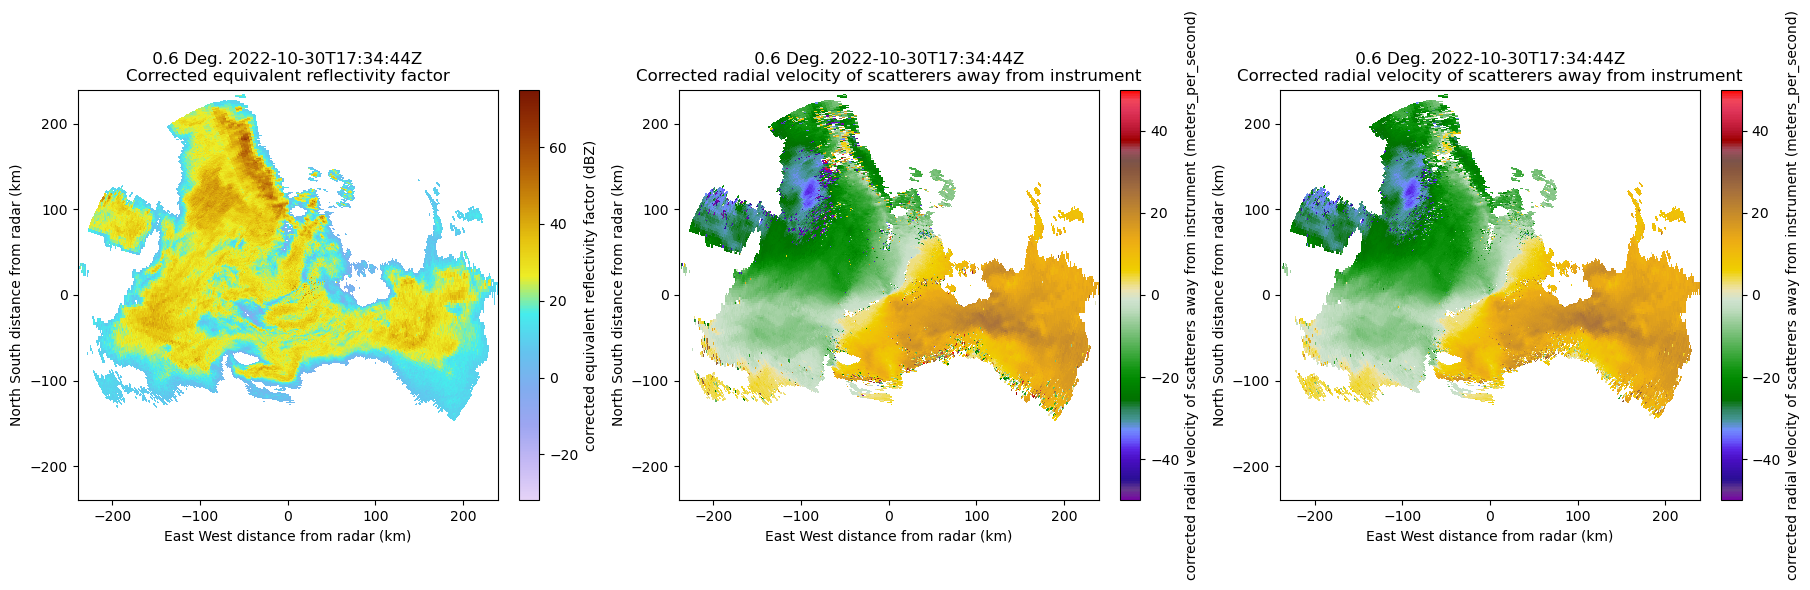

In [30]:
fig, axs = plt.subplots(1, 3, figsize = [18, 5], constrained_layout = True)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_reflectivity', 0, vmin = -32, vmax = 75, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0])
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('vcor_cmean', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[2])

It's easy to see that there was a significant improvent compared with the original field. However, the algorithm can't correct adequately areas plagued by a large number of bad gates as it needs at least two good neighboring gates in order to perform the correction. Nevertheless, we can use a simple filter based on a 3x3 moving window median filter to remove the remaining spackles. This will smooth the radial velocity field a little bit, but will eventualy get rid of these remaining speckles

In [31]:
vel_smooth = median_filter(radar.fields['vcor_cmean']['data'], 3)
smooth_data_ma = np.ma.masked_where(np.ma.getmask(radar.fields['vcor_cmean']['data']), vel_smooth)
smooth_data_ma = np.ma.masked_equal(smooth_data_ma, smooth_data_ma.min())
radar.add_field_like('vcor_cmean', 'vcor_cmean_smooth', 
                     smooth_data_ma, replace_existing = True)

The filtered vcor_cmean was added as the vcor_cmean_smooth variable. Let's check the results

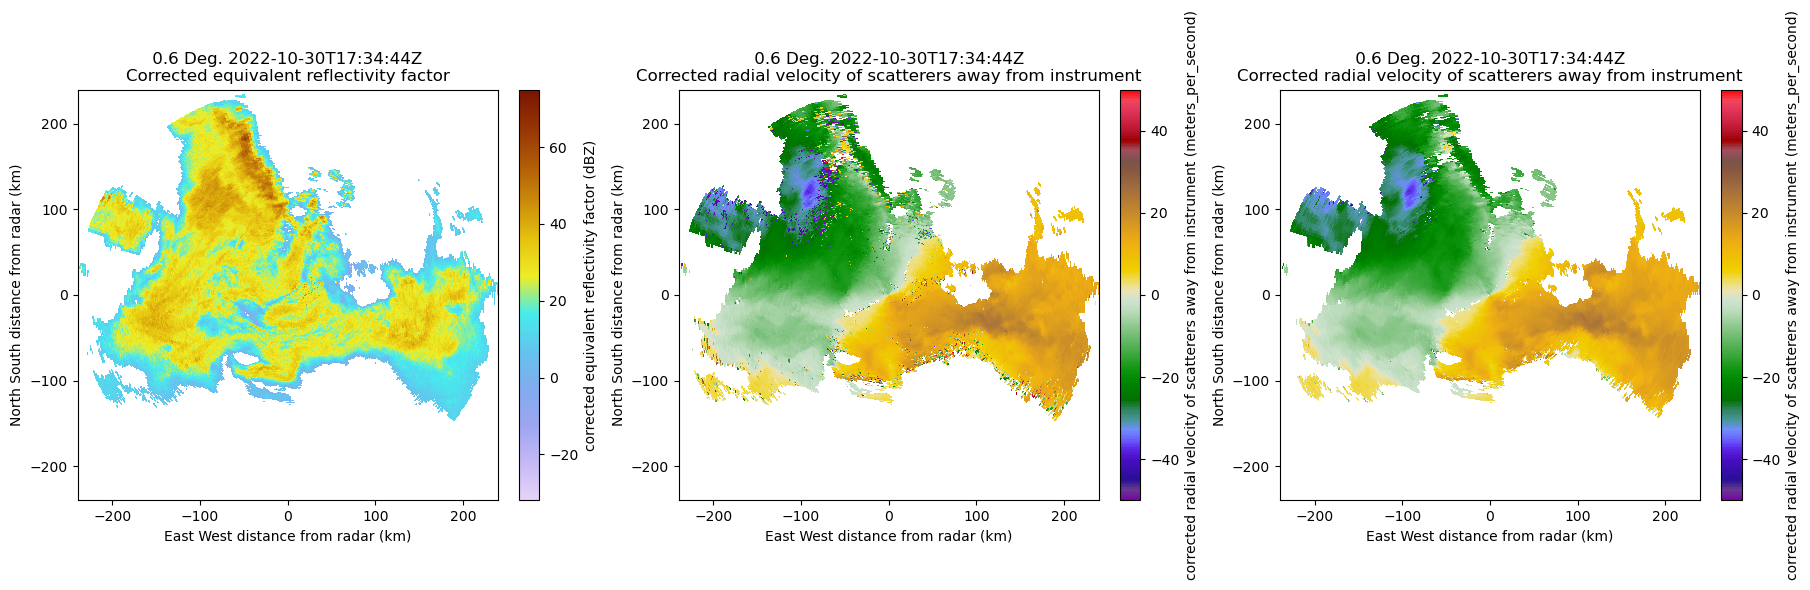

In [32]:
fig, axs = plt.subplots(1, 3, figsize = [18, 5], constrained_layout = True)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_reflectivity', 0, vmin = -32, vmax = 75, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0])
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('vcor_cmean_smooth', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[2])

We can see that most of the bad gates were finally corrected. A small number o speckles still remain but these are negligible. 
Finally, we can compare the improvement over each step.

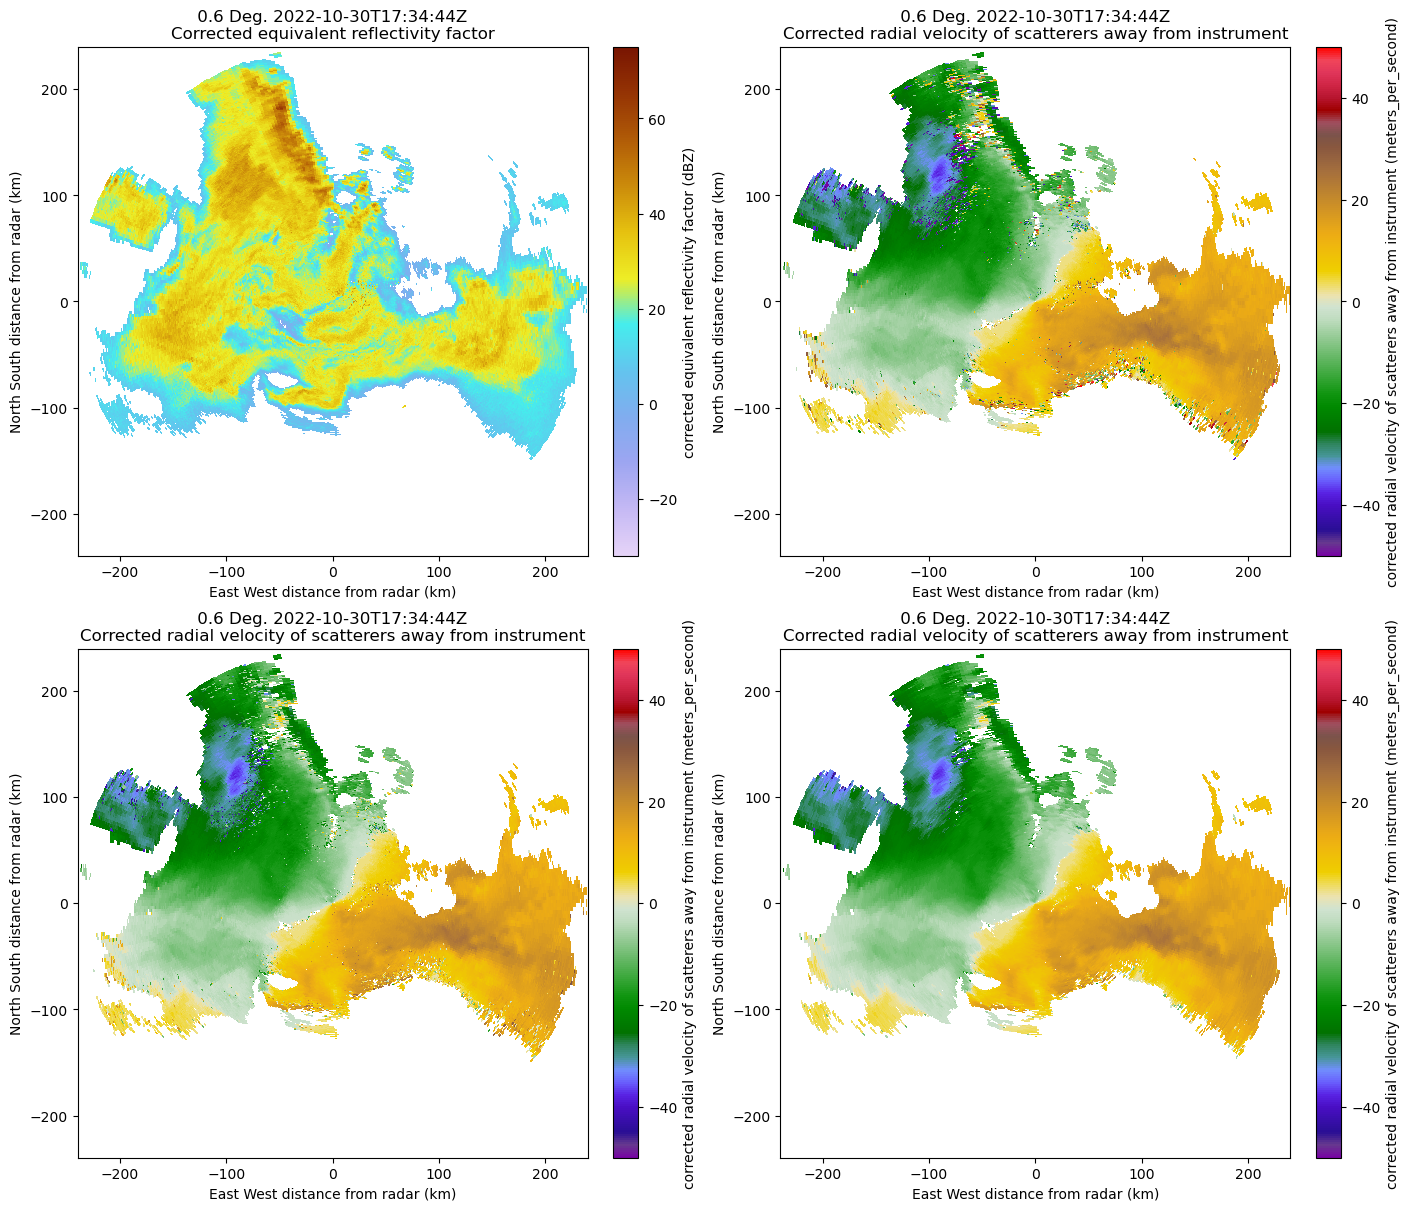

In [33]:
fig, axs = plt.subplots(2, 2, figsize = [14, 12], constrained_layout = True)

display = pyart.graph.RadarDisplay(radar)
display.plot_ppi('corrected_reflectivity', 0, vmin = -32, vmax = 75, cmap = pyart.graph.cm.LangRainbow12, ax = axs.ravel()[0])
display.plot_ppi('corrected_velocity', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[1])
display.plot_ppi('vcor_cmean', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[2])
display.plot_ppi('vcor_cmean_smooth', 0, vmin = -50, vmax = 50, cmap = pyart.graph.cm.Carbone42, ax = axs.ravel()[3])